In [1]:
import transformer_lens
import torch
#import numpy as np 

c:\Users\durrc\OneDrive\Desktop\mech_interp_project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
system_size=4

In [3]:
cfg = transformer_lens.HookedTransformerConfig(
    d_model=32,
    d_head = 8,
    n_layers=2,
    n_ctx=1+system_size,
    n_heads = 4,
    d_mlp = None,
    d_vocab=3,
    act_fn=None,
    attn_only=True,
    d_vocab_out=1
)

hooked_model = transformer_lens.HookedTransformer(
    cfg
)


In [4]:
def adapt_hooked_model(hooked_model):
    # give the hooked model params that are assumed to exist
    hooked_model.system_size = hooked_model.cfg.n_ctx-1
    hooked_model.system_sizes = [hooked_model.system_size]
    hooked_model.param_range = None
    hooked_model.embedding_size = hooked_model.cfg.d_model
    hooked_model.n_head = hooked_model.cfg.n_heads
    hooked_model.n_layers = hooked_model.cfg.n_layers
    hooked_model.size_idx=0
    


In [5]:
adapt_hooked_model(hooked_model)

In [6]:
from pruned_tqs.Hamiltonian import Ising
from pruned_tqs.optimizer import Optimizer

In [7]:
system_size = hooked_model.system_size

Hamiltonians = [Ising(system_size, periodic=False)]

param_dim = Hamiltonians[0].param_dim

c:\Users\durrc\OneDrive\Desktop\mech_interp_project\quantum_mech_interp\pruned_tqs\Hamiltonian_utils.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  system_size = torch.tensor(system_size, dtype=torch.int64).reshape(-1)


In [8]:
Hamiltonians[0].param_range *= 0
Hamiltonians[0].param_range +=1.0

In [9]:
optim = Optimizer(hooked_model, Hamiltonians, point_of_interest=None)

In [10]:
Hamiltonians[0].param_range[0,0].item()

1.0

In [36]:
Hamiltonians[0].symmetry

In [11]:
hooked_model.param_range

(tensor(1.), tensor(1.))

In [12]:
optim.train(
    5000,
    batch=1000, #1000000,
    max_unique=10,
    param_range=None, # use the hamiltonian's
    fine_tuning=False,
    use_SR=False,
    ensemble_id=int(False),
)

this is param range (1.0, 1.0)
i = 0	 E_real = 65.838837	 E_imag = -0.000001	 E_var = 620286.250000	 n = 4	 lr = 4.3933e-07 t = 0.444089  t_optim = 0.093590
this is param range (1.0, 1.0)
i = 1	 E_real = 68.218384	 E_imag = -0.000002	 E_var = 661011.500000	 n = 4	 lr = 8.7866e-07 t = 0.368513  t_optim = 0.094963
this is param range (1.0, 1.0)
i = 2	 E_real = 67.825958	 E_imag = -0.000002	 E_var = 678004.062500	 n = 4	 lr = 1.3180e-06 t = 0.363393  t_optim = 0.088930
this is param range (1.0, 1.0)
i = 3	 E_real = 69.268829	 E_imag = 0.000001	 E_var = 670934.625000	 n = 4	 lr = 1.7573e-06 t = 0.373317  t_optim = 0.084513
this is param range (1.0, 1.0)
i = 4	 E_real = 67.468719	 E_imag = 0.000001	 E_var = 636732.750000	 n = 4	 lr = 2.1966e-06 t = 0.361491  t_optim = 0.089944
this is param range (1.0, 1.0)
i = 5	 E_real = 66.172562	 E_imag = 0.000000	 E_var = 629330.687500	 n = 4	 lr = 2.6360e-06 t = 0.358513  t_optim = 0.086671
this is param range (1.0, 1.0)
i = 6	 E_real = 68.302094	 E_i

AssertionError: too many attempts

In [14]:
optim.model.evaluate_log_prob(
    1, 
    torch.tensor([[1,1,1,1]])
)

tensor([-24.6783], grad_fn=<SumBackward1>)

In [17]:
optim.model.evaluate_log_prob(
    1, 
    torch.tensor([[0,1,0,1]])
)

tensor([-10.4883], grad_fn=<SumBackward1>)

In [23]:
vals = []
for i in range(2**4):
    b = bin(i)[2:]
    b = '0'*(4-len(b))+b 
    vals.append([float(int(x)) for x in b])

0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111


In [24]:
outs = optim.model.evaluate_log_prob(
    1, 
    torch.tensor(vals)
)

In [35]:
from pruned_tqs import model_utils

In [39]:
outs.shape

torch.Size([16])

In [41]:
to_plot=model_utils.compute_psi(optim.model, samples=torch.tensor(vals).T, symmetry=Hamiltonians[0].symmetry)

In [46]:
to_plot[0].detach()

tensor([-1.0039, -2.3625, -2.5346, -4.8528, -2.5346, -1.8379, -1.6547, -2.3625,
        -2.3625, -1.6547, -1.8379, -2.5346, -4.8528, -2.5346, -2.3625, -1.0039])

In [51]:
import matplotlib.pyplot as plt 
import numpy as np

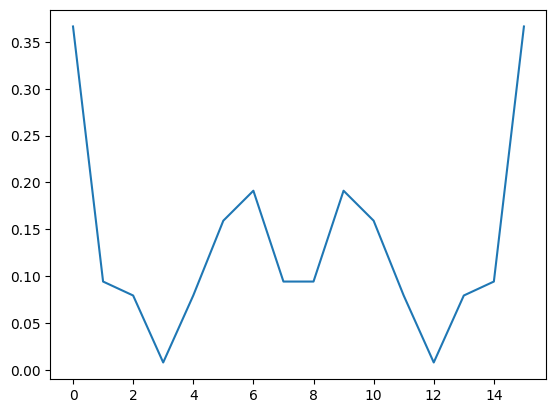

In [52]:
plt.plot(np.exp(to_plot[0].detach()))

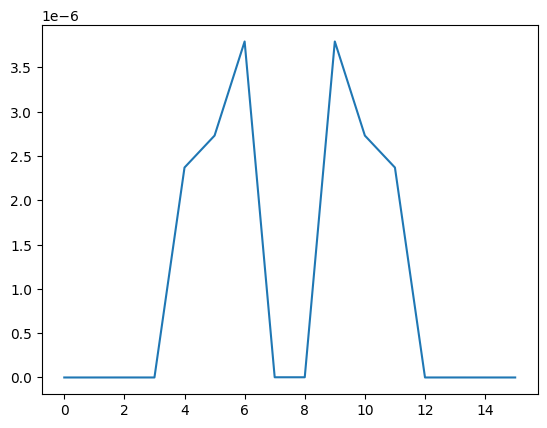

In [53]:
plt.plot(np.exp(outs.detach().numpy()+outs.detach().numpy()[::-1]))